In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import FastSeqProp
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [2]:
def unpickle_logs(log_path):
    log_df = pd.read_pickle(log_path + 'sequence_data.pkl')
    with open(log_path + 'top_ppms.pkl', 'rb') as fp:
        top_ppms = pickle.load(fp)
    return log_df, top_ppms

def plot_evol(traj, energy, step=1):
    timesteps, tokens, pos_ct = traj.shape
    x = np.linspace(0.5,pos_ct+0.5,pos_ct+1)
    y = np.linspace(0.,timesteps,(timesteps//step)+1)
    x,y = np.meshgrid(x,y)
    z = traj.argmax(1).float().add(0.50).numpy()
    z = z[np.arange(0,timesteps,step)]
    z = np.flip(z, axis=0)
    cmap = mp.colors.ListedColormap(['g', 'y', 'r', 'b'])
    bounds = [0.,1.,2.,3.,4.]
    ticks = [0.5,1.5,2.5,3.5]
    norm = mp.colors.BoundaryNorm(bounds, cmap.N)
    fig, axes = plt.subplots(1, 2, figsize = (15,40), gridspec_kw={'width_ratios':[10,1]}, constrained_layout=True)
    ax = axes[0]
    p = ax.pcolormesh(x,y,z, cmap=cmap, norm = norm)
    ax.axis([x.min(),x.max(),y.min(),y.max()])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = fig.colorbar(p, ax=ax, boundaries = bounds, 
                        ticks = ticks, location='top')
    cbar.set_ticklabels(['A','G','T','C'])
    
    ax = axes[1]
    ax.plot(energy[np.arange(0,timesteps,step)],np.flip(np.arange(timesteps//step)))
    ax.set_ylim([0,timesteps//step])
    
    plt.show()
    return plt, ax

## Individual log plots

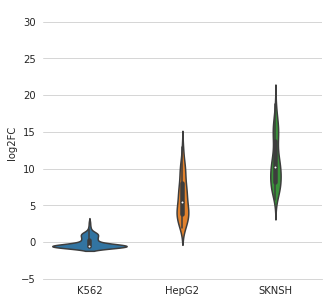

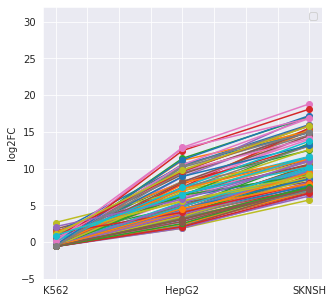

In [15]:
log_num = 28
penalty_num = 0

figsize_1 = (5,5)
figsize_2 = (6,3)

log_path = 'run_logs/log_' + str(log_num) + '/'
fig_path = log_path + 'figures/'

data_df, top_ppms = unpickle_logs(log_path)

#for penalty_num in range(6):

penalty_df = data_df[data_df['penalty_type'] == penalty_num]
prediction_array = np.stack(penalty_df['predictions'].values)
prediction_df = pd.DataFrame(prediction_array, columns=['K562', 'HepG2', "SKNSH"])

#sns.set(font_scale = 1.75)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=figsize_1)
    sns.violinplot(data=prediction_df)
    sns.despine(left=True)
    plt.ylabel('log2FC')
    plt.ylim(-5,32)
    plt.show()

# with sns.axes_style("white"):
#     plt.figure(figsize=figsize_2)
#     g = sns.histplot(data=penalty_df['entropy'], binrange=(0,1.2), color='k')
#     g.set(yticklabels=[])
#     g.set(ylabel=None)
#     sns.despine(left=True)
#     plt.xlabel('Entropy')
#     plt.show()
    
# sorted_penalty_df = penalty_df.sort_values(by='entropy').reset_index(drop=True)
# sequences_array = torch.tensor(np.stack(sorted_penalty_df['sequence'].values))
# entropies_array = torch.tensor(np.stack(sorted_penalty_df['entropy'].values))

# _ = plot_evol(sequences_array, entropies_array)


#-------------------- Best sequences --------------------
# lfc_threshold = 0
# other_type_1, other_type_2 = 'K562', 'HepG2'
# temp_df = pd.DataFrame(prediction_array, columns=['K562', 'HepG2', 'SKNSH'])
# #data_df[['K562', 'HepG2', 'SKNSH']] = prediction_array
# best_data = temp_df[(temp_df[other_type_1] <= lfc_threshold) & (temp_df[other_type_2] <= lfc_threshold)].to_numpy()
# print('')
# print(f'Number of sequences totally repressed in the other cell types: {len(best_data)}')
# print('')

# with sns.axes_style("whitegrid"):
#     plt.figure(figsize=figsize_1)
#     sns.violinplot(data=best_data)
#     sns.despine(left=True)
#     plt.ylabel('log2FC')
#     plt.ylim(-2,10)
#     plt.show()


#-------------------- Compare to previous run --------------------
# print('')
# print('Pre-GTEX run')
# log_num = 0

# log_path = 'run_logs/log_' + str(log_num) + '/'
# fig_path = log_path + 'figures/'

# data_df, top_ppms = unpickle_logs(log_path)

# penalty_df = data_df[data_df['penalty_type'] == penalty_num]
# prediction_array = np.stack(penalty_df['predictions'].values)
# prediction_df = pd.DataFrame(prediction_array, columns=['K562', 'HepG2', "SKNSH"])

# sns.set(font_scale = 1.75)

# with sns.axes_style("whitegrid"):
#     plt.figure(figsize=figsize_1)
#     sns.violinplot(data=prediction_df)
#     sns.despine(left=True)
#     plt.ylabel('log2FC')
#     plt.ylim(-2,10)
#     plt.show()

# with sns.axes_style("white"):
#     plt.figure(figsize=figsize_2)
#     g = sns.histplot(data=penalty_df['entropy'], binrange=(0,1.2), color='k')
#     g.set(yticklabels=[])
#     g.set(ylabel=None)
#     sns.despine(left=True)
#     plt.xlabel('Entropy')
#     plt.show()

with sns.axes_style("darkgrid"):
    prediction_df.T.plot(figsize=(5,5), style='-o')
    plt.ylim(-5,32)
    plt.legend('')
    plt.ylabel('log2FC')
    plt.show()

In [ ]:
log_num = 11
penalty_num = 0

figsize_1 = (5,5)
figsize_2 = (6,3)

log_path = 'run_logs/log_' + str(log_num) + '/'
fig_path = log_path + 'figures/'

data_df, top_ppms = unpickle_logs(log_path)

#for penalty_num in range(6):

penalty_df = data_df[data_df['penalty_type'] == penalty_num]
prediction_array = np.stack(penalty_df['predictions'].values)
prediction_df = pd.DataFrame(prediction_array, columns=['K562', 'HepG2', "SKNSH"])

#sns.set(font_scale = 1.75)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=figsize_1)
    sns.violinplot(data=prediction_df)
    sns.despine(left=True)
    plt.ylabel('log2FC')
    plt.ylim(-2,10)
    plt.show()
    
prediction_df.T.plot(figsize=(5,5), style='-o')
plt.ylim(-2,10)
plt.legend('')
plt.ylabel('log2FC')
plt.show()

In [ ]:
lfc_threshold = 0
other_type_1, other_type_2 = 'K562', 'HepG2'

data_df[['K562', 'HepG2', 'SKNSH']] = np.stack(data_df['predictions'].values)
best_data = data_df[(data_df[other_type_1] <= lfc_threshold) & (data_df[other_type_2] <= lfc_threshold)]

with sns.axes_style("whitegrid"):
    plt.figure(figsize=figsize_1)
    sns.violinplot(data=best_data[['K562', 'HepG2', 'SKNSH']].to_numpy())
    sns.despine(left=True)
    plt.ylabel('log2FC')
    plt.ylim(-2,10)
    plt.show()
    
print(len(best_data))

In [ ]:
penalty_df[['K562', 'HepG2', 'SKNSH']] = prediction_array
best_data = penalty_df[(penalty_df[other_type_1] <= lfc_threshold) & (penalty_df[other_type_2] <= lfc_threshold)]
best_data = best_data.sort_values(by='entropy').reset_index(drop=True)
best_sequences_array = torch.tensor(np.stack(best_data['sequence'].values))
best_entropies_array = torch.tensor(np.stack(best_data['entropy'].values))

_ = plot_evol(best_sequences_array, best_entropies_array)

In [ ]:
prediction_df.T.plot(figsize=(8,8), style='-o')
plt.legend('')
plt.show()